In [41]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import uuid
import random
import pyspark.pandas as ps
from datetime import datetime, timedelta
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_extract, when, round, regexp_replace, sum, sequence, to_date, lit, row_number, weekofyear
from pyspark.sql.window import Window
from datetime import datetime, date, timedelta
from pyspark.sql.types import StringType, IntegerType, FloatType, ArrayType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, explode
import pyarrow as pa
import pyarrow.parquet as pq

In [42]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "gcs_config.json"
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-11.0.7"
os.environ["SPARK_HOME"] = "C:/spark"
# findspark.init()
spark = SparkSession.builder.getOrCreate()

In [43]:
# Function to load data from GCS
def load_data_from_gcs(filepath):
    spark = SparkSession.builder \
        .appName("time series") \
        .config("spark.jars.packages", "com.google.cloud.bigdataoss:gcs-connector:hadoop3-2.2.22") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
        .config("google.cloud.auth.service.account.json.keyfile", "gcs_config.json") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    
    df = spark.read.parquet(filepath)

    return df

In [44]:
# Specify the path to the GCS Parquet file
gcs_parquet_path = 'gs://spicy_1/bigbasket_products*'
bigbasket_products_df = load_data_from_gcs(gcs_parquet_path)
bigbasket_products_df.show()

+-----+--------------------+--------------------+--------------------+-----------------+----------+------------+--------------------+------+--------------------+
|index|             product|            category|        sub_category|            brand|sale_price|market_price|                type|rating|         description|
+-----+--------------------+--------------------+--------------------+-----------------+----------+------------+--------------------+------+--------------------+
|    1|Garlic Oil - Vege...|    Beauty & Hygiene|           Hair Care|Sri Sri Ayurveda |     220.0|       220.0|    Hair Oil & Serum|   4.1|This Product cont...|
|    2|Water Bottle - Or...|Kitchen, Garden &...|Storage & Accesso...|       Mastercook|     180.0|       180.0|Water & Fridge Bo...|   2.3|Each product is m...|
|    3|Brass Angle Deep ...|Cleaning & Household|         Pooja Needs|              Trm|     119.0|       250.0|     Lamp & Lamp Oil|   3.4|A perfect gift fo...|
|    4|Cereal Flip Lid C...|

# time series analysis

In [113]:
gcs_parquet_path = 'gs://spicy_1/customer_purchase*'
df_c2c = load_data_from_gcs(gcs_parquet_path)

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_c2c.count(), len(df_c2c.columns)))

# Show the first few rows of the DataFrame
df_c2c.show()

Shape of DataFrame: (236463, 6)
+-----------+------------------+--------------------+----------+--------+-------------+
|customer_id|     customer_name|        product_name|unit_price|quantity|purchase_date|
+-----------+------------------+--------------------+----------+--------+-------------+
|        212|     Monica Lozano|MTR Ready Mix Upm...|      0.51|       3|   2024-04-05|
|        419|    Christine Hill|Catch Red Chilli ...|       0.5|       1|   2024-04-19|
|        282|   Tracy Young DDS|Bulk Vegan Protei...|      1.15|       3|   2024-03-29|
|        115|        Bryan King|Preserve - Blackc...|      4.23|       3|   2024-04-04|
|        438|    Jason Campbell|Deccan Gold - Org...|      3.41|       3|   2024-04-09|
|        213|Garrett Montgomery|             Tur Dal|      0.87|       3|   2024-03-20|
|        291|       Luke Curtis|Grape Fruit - Indian|      0.87|       1|   2024-05-23|
|        322|      Willie Ramos|Chilli Lemon Gril...|      0.38|       2|   2024-05-01|


In [114]:
# Calculate total price for each row
df_c2c = df_c2c.withColumn("total_price", col("unit_price") * col("quantity"))

# Aggregate the data by date
daily_sales = df_c2c.groupBy("purchase_date").agg(sum("total_price").alias("total_sales"))

daily_sales= daily_sales.withColumn("total_sales", round(daily_sales['total_sales'], 2))

daily_sales.show()

# Convert to Pandas DataFrame for time series analysis
df_sales = daily_sales.toPandas()
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'])
df_sales= df_sales.sort_values("purchase_date")
print(df_sales.head())

+-------------+-----------+
|purchase_date|total_sales|
+-------------+-----------+
|   2024-01-19|    1214.72|
|   2024-04-03|   11215.82|
|   2024-02-08|     4388.3|
|   2024-02-28|    6088.12|
|   2024-01-13|      35.36|
|   2024-02-20|    4410.89|
|   2024-04-10|   10932.45|
|   2024-04-14|     9956.1|
|   2024-01-06|      65.38|
|   2024-04-07|   10622.08|
|   2024-03-03|     7435.7|
|   2024-05-19|   12180.72|
|   2024-02-04|    4987.24|
|   2024-04-27|    12176.4|
|   2024-03-26|   11200.94|
|   2024-02-15|    4033.34|
|   2024-02-12|    4274.96|
|   2024-02-26|    7707.56|
|   2024-05-24|   12145.62|
|   2024-01-14|       14.8|
+-------------+-----------+
only showing top 20 rows

  purchase_date  total_sales
0    2024-01-19      1214.72
1    2024-04-03     11215.82
2    2024-02-08      4388.30
3    2024-02-28      6088.12
4    2024-01-13        35.36
    purchase_date  total_sales
144    2024-01-01         1.83
40     2024-01-02         5.84
95     2024-01-03       143.49
88  

In [115]:
df_sales

,purchase_date,total_sales
144,2024-01-01,1.83
40,2024-01-02,5.84
95,2024-01-03,143.49
88,2024-01-04,59.31
109,2024-01-05,42.04
...,...,...
72,2024-05-27,12489.90
34,2024-05-28,12965.38
142,2024-05-29,12429.15
62,2024-05-30,13237.70


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\ariji\AppData\Local\Temp\tmpeqih3nh2\sc97vai5.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ariji\AppData\Local\Temp\tmpeqih3nh2\sikoq82e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\ariji\\Anaconda3\\envs\\python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=40353', 'data', 'file=C:\\Users\\ariji\\AppData\\Local\\Temp\\tmpeqih3nh2\\sc97vai5.json', 'init=C:\\Users\\ariji\\AppData\\Local\\Temp\\tmpeqih3nh2\\sikoq82e.json', 'output', 'file=C:\\Users\\ariji\\AppData\\Local\\Temp\\tmpeqih3nh2\\prophet_modelfrn7el7o\\prophet_model-20240527014534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:34 - cmdstanpy - INFO - Chain [1] done pro

    purchase_date  total_sales
144    2024-01-01         1.83
40     2024-01-02         5.84
95     2024-01-03       143.49
88     2024-01-04        59.31
109    2024-01-05        42.04
            ds       y
144 2024-01-01    1.83
40  2024-01-02    5.84
95  2024-01-03  143.49
88  2024-01-04   59.31
109 2024-01-05   42.04


INFO:cmdstanpy:Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
0   2024-01-01      0.000000      0.000000    512.085928
1   2024-01-02      0.000000      0.000000    833.990837
2   2024-01-03      6.682974      0.000000    780.813808
3   2024-01-04    238.220951      0.000000   1008.711450
4   2024-01-05    425.571297      0.000000   1169.181347
..         ...           ...           ...           ...
512 2025-05-27  46727.791886  45965.791041  47537.136937
513 2025-05-28  46603.185461  45871.602110  47385.797137
514 2025-05-29  46701.831286  45874.818969  47499.751966
515 2025-05-30  46840.184050  46055.537700  47606.969676
516 2025-05-31  46731.072866  45996.496608  47570.944487

[517 rows x 4 columns]


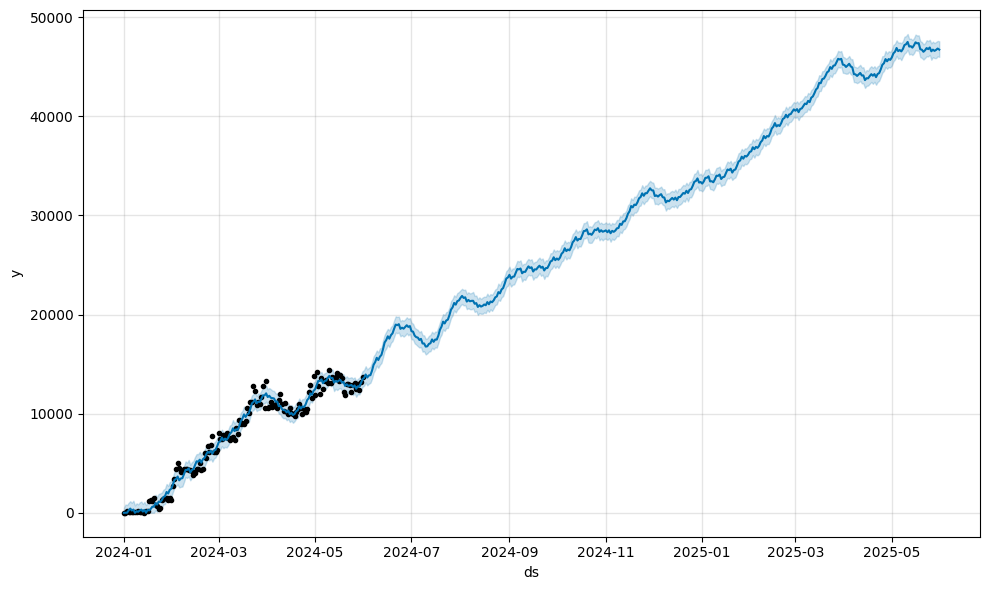

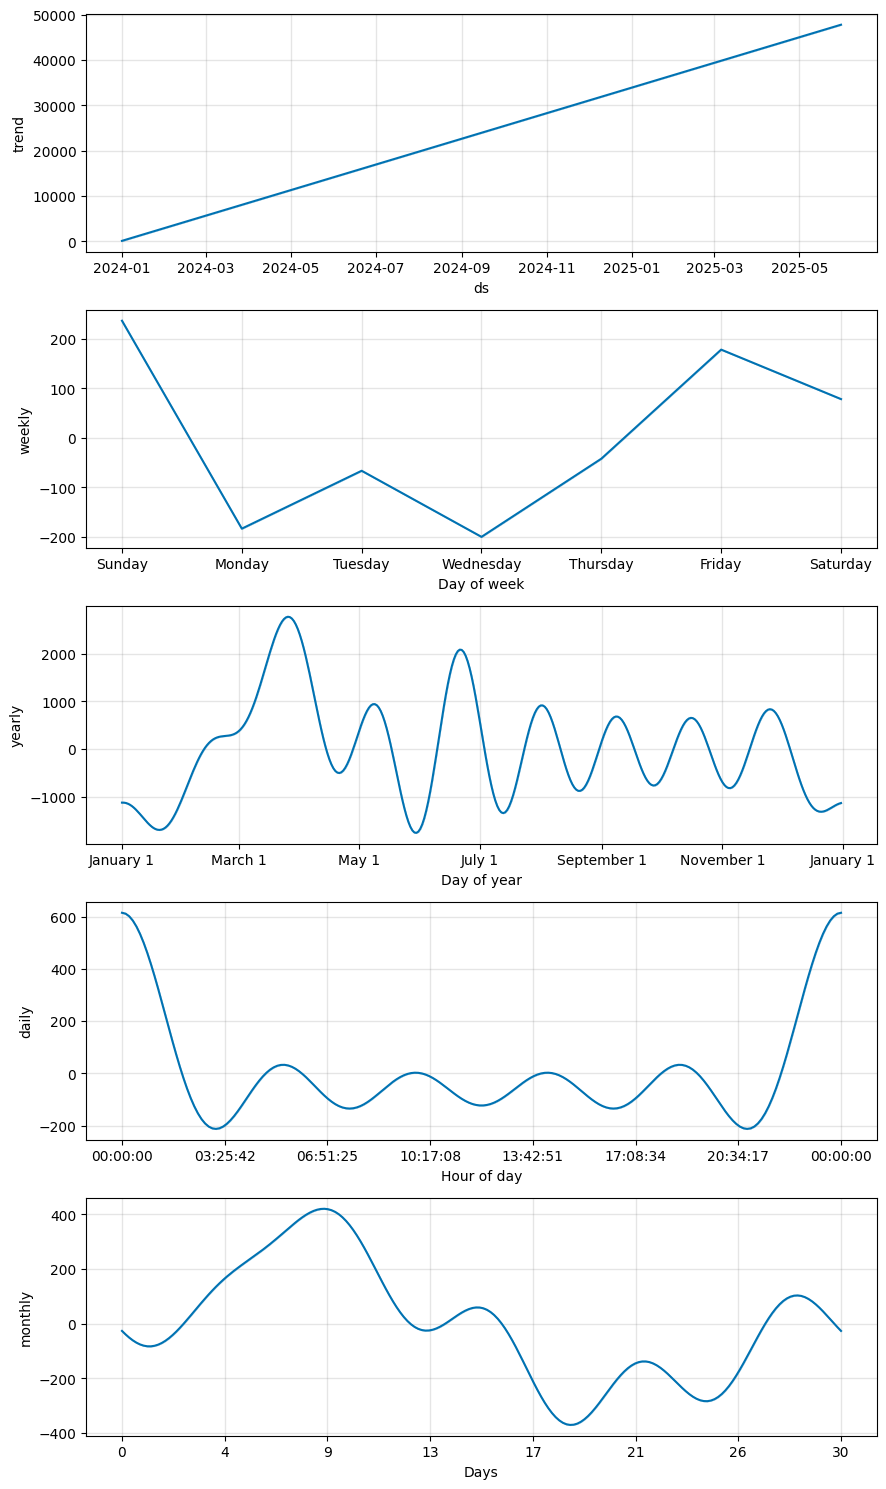

In [230]:
from prophet import Prophet

prophet_df= df_sales.copy()
print(prophet_df.head())
prophet_df.rename(columns={'purchase_date': 'ds', 'total_sales': 'y'}, inplace=True)
print(prophet_df.head())

# Initialize the model with tuned parameters
model = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='weekly', period=7, fourier_order=5)
model.add_seasonality(name='monthly', period=30, fourier_order=5) 
model.add_seasonality(name='daily', period=1, fourier_order=5)
# model.add_seasonality(name='yearly', period=365, fourier_order=5) 
model.fit(prophet_df)

# Create a DataFrame to hold future dates
future = model.make_future_dataframe(periods=365)

# Predict future sales
forecast = model.predict(future)

# Post-process to ensure non-negative predictions
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, x))
forecast['yhat_lower'] = forecast['yhat_lower'].apply(lambda x: max(0, x))
forecast['yhat_upper'] = forecast['yhat_upper'].apply(lambda x: max(0, x))

# Plot the forecast
model.plot(forecast)

# Plot components of the forecast
model.plot_components(forecast)

# Extract the forecasted data for the next year
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(700)
print(future_forecast)

In [237]:
df= future_forecast[['ds', 'yhat']]
df['month'] = df['ds'].dt.isocalendar().month
df['year'] = df['ds'].dt.year
weekly_sales = df.groupby(['year', 'week']).agg({'yhat': 'sum'}).reset_index()
weekly_sales

AttributeError: 'DataFrame' object has no attribute 'month'

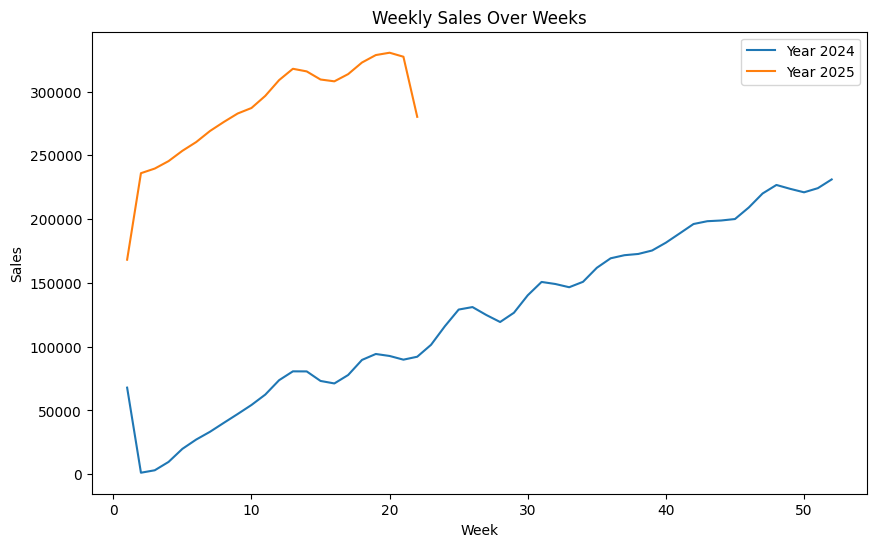

In [236]:
fig, ax = plt.subplots(figsize=(10, 6))
for year in weekly_sales['year'].unique():
    year_data = weekly_sales[weekly_sales['year'] == year]
    ax.plot(year_data['week'], year_data['yhat'], label=f'Year {year}')

ax.set_title('Weekly Sales Over Weeks')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
ax.legend()

In [117]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Split data into training and test sets
# train_df = prophet_df[prophet_df['ds'] < '2024-04-01']
# test_df = prophet_df[prophet_df['ds'] >= '2024-04-01']

# # Initialize the model with tuned parameters
# model2 = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# model2.add_seasonality(name='weekly', period=7, fourier_order=5)
# model2.add_seasonality(name='monthly', period=30, fourier_order=5) 

# # Fit the model on the training data
# model2.fit(train_df)

# # Create a DataFrame to hold test dates
# test_dates = test_df[['ds']]

# # Predict on the test set
# forecast = model2.predict(test_dates)

# # Post-process to ensure non-negative predictions
# forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, x))

# # Merge the forecast with the test set
# test_df = test_df.set_index('ds').join(forecast.set_index('ds')[['yhat']])

# # Calculate error metrics
# mae = mean_absolute_error(test_df['y'], test_df['yhat'])
# mse = mean_squared_error(test_df['y'], test_df['yhat'])
# rmse = np.sqrt(mse)
# r2 = r2_score(test_df['y'], test_df['yhat'])

# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"R² Score: {r2}")

# ML models time series using mllib

In [150]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lag,  month, dayofmonth, year, dayofweek, quarter, dayofyear, weekofyear, to_date

In [151]:
daily_sales= daily_sales.orderBy("purchase_date")
daily_sales.show()

+-------------+-----------+
|purchase_date|total_sales|
+-------------+-----------+
|   2024-01-01|       1.83|
|   2024-01-02|       5.84|
|   2024-01-03|     143.49|
|   2024-01-04|      59.31|
|   2024-01-05|      42.04|
|   2024-01-06|      65.38|
|   2024-01-07|     116.31|
|   2024-01-08|     115.93|
|   2024-01-09|     126.93|
|   2024-01-10|      135.7|
|   2024-01-11|      29.69|
|   2024-01-12|       51.6|
|   2024-01-13|      35.36|
|   2024-01-14|       14.8|
|   2024-01-15|     219.16|
|   2024-01-16|     150.95|
|   2024-01-17|    1210.48|
|   2024-01-18|     1306.7|
|   2024-01-19|    1214.72|
|   2024-01-20|    1538.48|
+-------------+-----------+
only showing top 20 rows



In [152]:
def create_features(data):
    data = data.withColumn("month", month(col("purchase_date"))) \
               .withColumn("day", dayofmonth(col("purchase_date"))) \
               .withColumn("quarter", quarter(col("purchase_date"))) \
               .withColumn("dayofyear", dayofyear(col("purchase_date"))) \
               .withColumn("week", weekofyear(col("purchase_date")))
    return data

In [153]:
# .withColumn("year", year(col("purchase_date"))) \
# .withColumn("dayofweek", dayofweek(col("purchase_date"))) \

In [154]:
df_features= create_features(daily_sales)
df_features.show()

+-------------+-----------+-----+---+-------+---------+----+
|purchase_date|total_sales|month|day|quarter|dayofyear|week|
+-------------+-----------+-----+---+-------+---------+----+
|   2024-01-01|       1.83|    1|  1|      1|        1|   1|
|   2024-01-02|       5.84|    1|  2|      1|        2|   1|
|   2024-01-03|     143.49|    1|  3|      1|        3|   1|
|   2024-01-04|      59.31|    1|  4|      1|        4|   1|
|   2024-01-05|      42.04|    1|  5|      1|        5|   1|
|   2024-01-06|      65.38|    1|  6|      1|        6|   1|
|   2024-01-07|     116.31|    1|  7|      1|        7|   1|
|   2024-01-08|     115.93|    1|  8|      1|        8|   2|
|   2024-01-09|     126.93|    1|  9|      1|        9|   2|
|   2024-01-10|      135.7|    1| 10|      1|       10|   2|
|   2024-01-11|      29.69|    1| 11|      1|       11|   2|
|   2024-01-12|       51.6|    1| 12|      1|       12|   2|
|   2024-01-13|      35.36|    1| 13|      1|       13|   2|
|   2024-01-14|       14

In [155]:
# # Create lag features for a week 7 days
# window = Window.orderBy("purchase_date")
# for i in range(1, 4):
#     daily_sales = daily_sales.withColumn(f"lag_{i}", lag(col("total_sales"), i).over(window))

# # Drop rows with null values (introduced by lagging)
# daily_sales = daily_sales.na.drop()

# daily_sales.show()

In [ ]:
# # creating train and test splits
# # Split the data into training and test sets
# train_df = df_features.filter(col("purchase_date") < "2024-05-01")
# test_df = df_features.filter(col("purchase_date") >= "2024-05-01")

# # Create feature columns list
# feature_cols = ["month", "day", "year", "dayofweek", "quarter", "dayofyear"]

# # Assemble features into a feature vector
# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# train_df = assembler.transform(train_df)
# test_df = assembler.transform(test_df)

# # Print the shape of the DataFrame
# print("Shape of DataFrame: ({}, {})".format(train_df.count(), len(train_df.columns)))
# train_df.show()

# # Print the shape of the DataFrame
# print("Shape of DataFrame: ({}, {})".format(test_df.count(), len(test_df.columns)))
# test_df.show()

In [ ]:
# def train_and_evaluate_model(model_name, metric_name, train_data, test_data):
#     if model_name == 'linear_regression':
#         model= LinearRegression(featuresCol= "features", labelCol= "total_sales", predictionCol= 'prediction')
#     elif model_name == 'decision_tree':
#         model= DecisionTreeRegressor(featuresCol= "features", labelCol= "total_sales", maxDepth= 20)
#     elif model_name == 'random_forest':
#         model = RandomForestRegressor(featuresCol="features", labelCol="total_sales", numTrees= 100)
#     elif model_name == 'gradient_boosting':
#         model = GBTRegressor(featuresCol="features", labelCol="total_sales", maxIter= 100)
#     else:
#         raise ValueError(f"Model {model_name} is not supported")

#     # Train the model
#     model_fit = model.fit(train_data)

#     # predicting on train data
#     train_predictions = model_fit.transform(train_data)
    
#     # Predict on the test set
#     test_predictions = model_fit.transform(test_data)

#     # Evaluate the train model
#     evaluator = RegressionEvaluator(labelCol="total_sales", predictionCol="prediction", metricName=metric_name)
#     train_score = evaluator.evaluate(train_predictions)
    
#     # Evaluate the test model
#     evaluator = RegressionEvaluator(labelCol="total_sales", predictionCol="prediction", metricName=metric_name)
#     test_score = evaluator.evaluate(test_predictions)
    
#     return train_score, test_score, train_predictions, test_predictions

# # Example usage:
# metrics = ['mae']
# models = ['linear_regression', 'decision_tree', 'random_forest', 'gradient_boosting']

# for model_name in models:
#     print(f"Evaluating {model_name} model:")
#     for metric in metrics:
#         train_score, test_score, train_predictions, test_predictions = train_and_evaluate_model(model_name, metric, train_df, test_df)
#         print(f"{metric.upper()}: {train_score}, {test_score}")

In [202]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, dayofmonth, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

def train_and_evaluate_model(df, metric_name='mae'):
    # add features
    df_features= create_features(df)
    df_features.show()
    
    # Assemble features
    feature_cols = ["month", "day", "week", "quarter", "dayofyear"]
    vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    data = vector_assembler.transform(df_features)
    
    # Split data into training and test sets
    train_data = data.filter(col("purchase_date") <= "2024-04-30")
    test_data = data.filter(col("purchase_date") > "2024-04-30")

    # Define models
    models = {
        'linear_regression': LinearRegression(featuresCol="features", labelCol="total_sales", maxIter= 100, elasticNetParam= 0.1),
        'decision_tree': DecisionTreeRegressor(featuresCol="features", labelCol="total_sales", maxDepth=20),
        'random_forest': RandomForestRegressor(featuresCol="features", labelCol="total_sales", maxDepth=20, numTrees=100),
        'gradient_boosting': GBTRegressor(featuresCol="features", labelCol="total_sales",  maxDepth=20, maxIter= 100)
    }
    
    best_model_name = None
    best_model_fit = None
    best_test_score = float("inf")

    for model_name, model in models.items():
        # Train the model
        model_fit = model.fit(data)
        
        # Predict on the test set
        test_predictions = model_fit.transform(data)
        
        # Evaluate the model
        evaluator = RegressionEvaluator(labelCol="total_sales", predictionCol="prediction", metricName=metric_name)
        test_score = evaluator.evaluate(test_predictions)
        
        print(f"Model: {model_name}, {metric_name.upper()}: {test_score}")
        
        # Select the best model
        if test_score < best_test_score:
            best_test_score = test_score
            best_model_name = model_name
            best_model_fit = model_fit

    print(f"Best Model: {best_model_name}, {metric_name.upper()}: {best_test_score}")
    return best_model_fit

In [203]:
best_model_fit = train_and_evaluate_model(daily_sales)

+-------------+-----------+-----+---+-------+---------+----+
|purchase_date|total_sales|month|day|quarter|dayofyear|week|
+-------------+-----------+-----+---+-------+---------+----+
|   2024-01-01|       1.83|    1|  1|      1|        1|   1|
|   2024-01-02|       5.84|    1|  2|      1|        2|   1|
|   2024-01-03|     143.49|    1|  3|      1|        3|   1|
|   2024-01-04|      59.31|    1|  4|      1|        4|   1|
|   2024-01-05|      42.04|    1|  5|      1|        5|   1|
|   2024-01-06|      65.38|    1|  6|      1|        6|   1|
|   2024-01-07|     116.31|    1|  7|      1|        7|   1|
|   2024-01-08|     115.93|    1|  8|      1|        8|   2|
|   2024-01-09|     126.93|    1|  9|      1|        9|   2|
|   2024-01-10|      135.7|    1| 10|      1|       10|   2|
|   2024-01-11|      29.69|    1| 11|      1|       11|   2|
|   2024-01-12|       51.6|    1| 12|      1|       12|   2|
|   2024-01-13|      35.36|    1| 13|      1|       13|   2|
|   2024-01-14|       14

In [206]:
def forecast_and_plot(model_fit, df, forecast_start_date, forecast_end_date):
    data = create_features(df)

    # Convert to Pandas DataFrame for plotting
    original_data_pd = data.select("purchase_date", "total_sales").toPandas()

    # Generate future dates
    # last_date = data.select("purchase_date").orderBy(col("purchase_date").desc()).first()[0]
    future_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, normalize=True)

    # Create DataFrame for future dates
    future_data_pd = pd.DataFrame({"purchase_date": future_dates})
    future_data = spark.createDataFrame(future_data_pd)

    # future_data.show()
    
    # Extract month and day features for future dates
    future_data = create_features(future_data)

    # future_data.show()
    
    # Assemble features for future dates
    feature_cols = ["month", "day", "week", "quarter", "dayofyear"]
    vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    future_data = vector_assembler.transform(future_data)

    # future_data.show()

    # Make predictions
    future_predictions = model_fit.transform(future_data)

    future_predictions.show()
    
    # Convert predictions to Pandas DataFrame
    future_predictions_pd = future_predictions.select("purchase_date", "prediction").toPandas()

    # print(future_predictions_pd.head())

    # Combine original and forecasted data
    combined_data_pd = pd.concat([original_data_pd, future_predictions_pd.rename(columns={"prediction": "total_sales"})])

    combined_data_pd["purchase_date"] = pd.to_datetime(combined_data_pd["purchase_date"])

    print(combined_data_pd.head())

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(future_predictions_pd['purchase_date'], future_predictions_pd['prediction'])
    # plt.xlabel("date")
    # plt.ylabel("Total Sales")
    plt.title('Total Sales Forecast')
    plt.legend()
    plt.show()

+-------------------+-----+---+-------+---------+----+--------------------+------------------+
|      purchase_date|month|day|quarter|dayofyear|week|            features|        prediction|
+-------------------+-----+---+-------+---------+----+--------------------+------------------+
|2024-01-01 00:00:00|    1|  1|      1|        1|   1|[1.0,1.0,1.0,1.0,...|              1.83|
|2024-01-02 00:00:00|    1|  2|      1|        2|   1|[1.0,2.0,1.0,1.0,...|              5.84|
|2024-01-03 00:00:00|    1|  3|      1|        3|   1|[1.0,3.0,1.0,1.0,...|            143.49|
|2024-01-04 00:00:00|    1|  4|      1|        4|   1|[1.0,4.0,1.0,1.0,...|             59.31|
|2024-01-05 00:00:00|    1|  5|      1|        5|   1|[1.0,5.0,1.0,1.0,...| 42.03999999999999|
|2024-01-06 00:00:00|    1|  6|      1|        6|   1|[1.0,6.0,1.0,1.0,...|             65.38|
|2024-01-07 00:00:00|    1|  7|      1|        7|   1|[1.0,7.0,1.0,1.0,...|            116.31|
|2024-01-08 00:00:00|    1|  8|      1|        8| 

  purchase_date  total_sales
0    2024-01-01         1.83
1    2024-01-02         5.84
2    2024-01-03       143.49
3    2024-01-04        59.31
4    2024-01-05        42.04


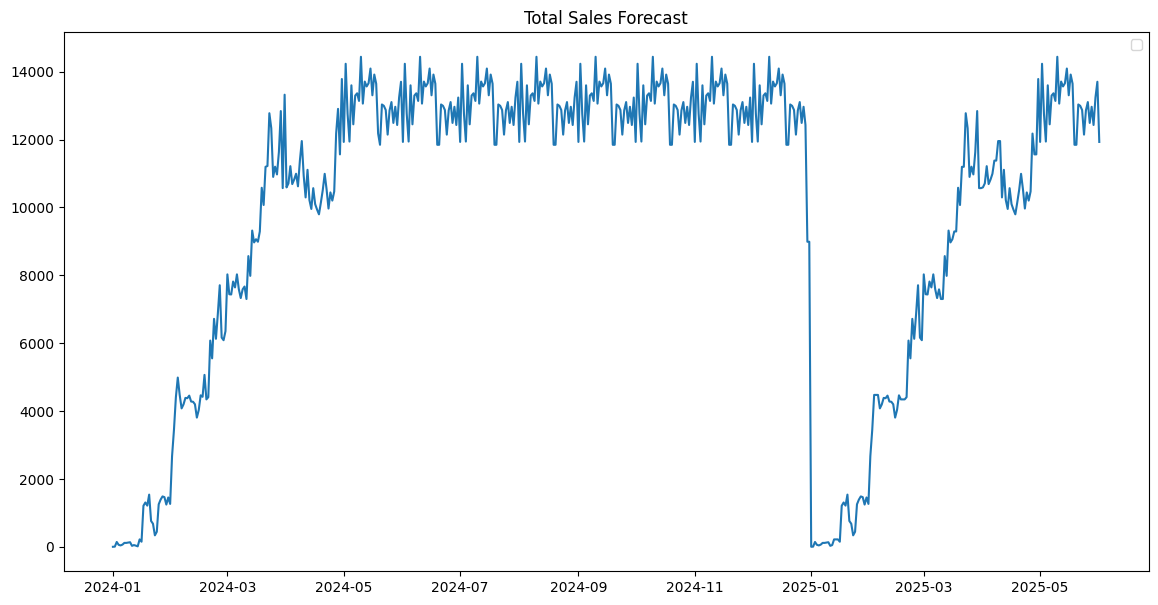

In [207]:
# Forecast and plot the results
forecast_start_date= "2024-01-01"
forecast_end_date = "2025-06-01"
forecast_and_plot(best_model_fit, daily_sales, forecast_start_date, forecast_end_date)

In [81]:
# def forecast_future_sales(df, model, steps=365, lag=7):
#     future_predictions = []
#     df = df.orderBy("purchase_date").toPandas()
    
#     for i in range(steps):
#         features = df.iloc[-lag:]['total_sales'].values.flatten().reshape(1, -1)
#         features = np.pad(features, (lag - len(features[0]), 0), mode='constant')  # Ensure features have correct length
#         prediction = model.predict(features)[0]
#         future_predictions.append(prediction)

#         # Append the new prediction to the DataFrame
#         new_row = {'purchase_date': df['purchase_date'].max() + pd.Timedelta(days=1), 'total_sales': prediction}
#         for j in range(1, lag+1):
#             new_row[f'lag_{j}'] = future_predictions[-j] if len(future_predictions) >= j else df['total_sales'].iloc[-j]
        
#         df = df.append(new_row, ignore_index=True)
    
#     return future_predictions

# # Use the Random Forest model for future prediction as an example
# rf_model = RandomForestRegressor(featuresCol="features", labelCol="total_sales", numTrees=100).fit(train_df)
# future_sales_rf = forecast_future_sales(daily_sales, rf_model, steps=365)
# print(future_sales_rf)

In [31]:
# Train Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="total_sales")
lr_model = lr.fit(train_df)

# Predict on test set
lr_predictions = lr_model.transform(test_df)

# Evaluate Linear Regression model
evaluator = RegressionEvaluator(labelCol="total_sales", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(lr_predictions)
mse = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(lr_predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

Linear Regression - MAE: 532.3801418451826, MSE: 487412.03122250043, RMSE: 698.1490035962956, R²: -0.06037078371675353


# old data 

In [4]:
df_ts_filtered= df_ts.select("date", "price")

# Group by day and week, then aggregate prices by summing them
result_df = df_ts_filtered.groupBy("date").agg(sum("price").alias("sales"))
result_df = result_df.withColumn("sales", round(result_df['sales'], 2))
print("Shape of DataFrame: ({}, {})".format(result_df.count(), len(result_df.columns)))

result_df= result_df.orderBy("date")

result_df.show()

Shape of DataFrame: (728, 2)
+----------+-------+
|      date|  sales|
+----------+-------+
|2023-01-02|  98.96|
|2023-01-03| 182.32|
|2023-01-04| 304.36|
|2023-01-05| 152.09|
|2023-01-06| 120.32|
|2023-01-07|2610.12|
|2023-01-08|2060.67|
|2023-01-09| 2388.3|
|2023-01-10|2740.72|
|2023-01-11|4277.73|
|2023-01-12|4646.37|
|2023-01-13|4814.02|
|2023-01-14|7126.08|
|2023-01-15|5797.11|
|2023-01-16|7650.28|
|2023-01-17|7140.87|
|2023-01-18|8913.47|
|2023-01-19|11902.0|
|2023-01-20|9789.88|
|2023-01-21|7927.95|
+----------+-------+
only showing top 20 rows



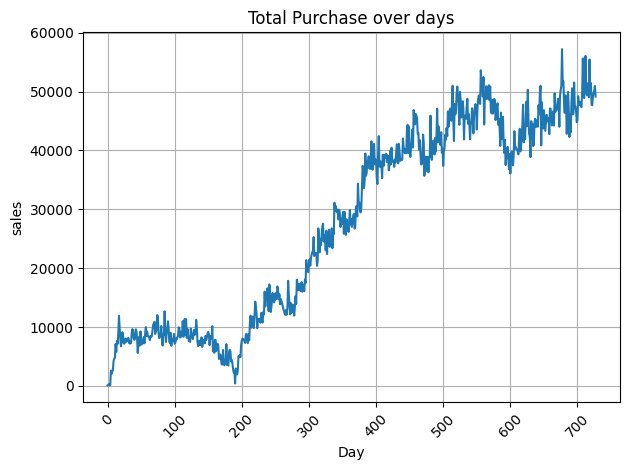

In [5]:
pandas_df= result_df.toPandas()
plt.plot(pandas_df['sales'])
# Formatting the plot
plt.title('Total Purchase over days')
plt.xlabel('Day')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from pyspark.sql.functions import col, countDistinct, sum, avg, lag, monotonically_increasing_id
from pyspark.sql.window import Window

agg_df = df_ts.groupBy("date").agg(
    countDistinct("location_id").alias("unique_locations"),
    countDistinct("postal_code").alias("unique_postal_codes"),
    countDistinct("customer_id").alias("unique_customers"),
    sum("price").alias("total_sales"),
    countDistinct("store_id").alias("unique_stores")
).orderBy("date")
agg_df= agg_df.withColumn("total_sales", round(agg_df['total_sales'], 2))
agg_df.show()

# Assuming you want to forecast based on postal_code and location_id
postal_code_agg = df_ts.groupBy("date", "postal_code").agg(
    sum("price").alias("total_sales_postal_code")
).orderBy("date")
postal_code_agg= postal_code_agg.withColumn("total_sales_postal_code", round(postal_code_agg['total_sales_postal_code'], 2))
postal_code_agg.show()

location_id_agg = df_ts.groupBy("date", "location_id").agg(
    sum("price").alias("total_sales_location_id")
).orderBy("date")
location_id_agg= location_id_agg.withColumn("total_sales_location_id", round(location_id_agg['total_sales_location_id'], 2))
location_id_agg.show()

# # Join aggregated data
# result_df = agg_df.join(postal_code_agg, on="date", how="left").join(location_id_agg, on="date", how="left")

# # Sort the resulting DataFrame by the date column
# sorted_df = result_df.orderBy("date")

# sorted_df.show()

+----------+----------------+-------------------+----------------+-----------+-------------+
|      date|unique_locations|unique_postal_codes|unique_customers|total_sales|unique_stores|
+----------+----------------+-------------------+----------------+-----------+-------------+
|2023-01-02|               1|                  1|               1|      98.96|           62|
|2023-01-03|               1|                  1|               1|     182.32|           69|
|2023-01-04|               2|                  2|               2|     304.36|          109|
|2023-01-05|               2|                  2|               2|     152.09|           71|
|2023-01-06|               2|                  2|               2|     120.32|           50|
|2023-01-07|              21|                 21|              21|    2610.12|          296|
|2023-01-08|              20|                 20|              21|    2060.67|          288|
|2023-01-09|              22|                 20|              22|    

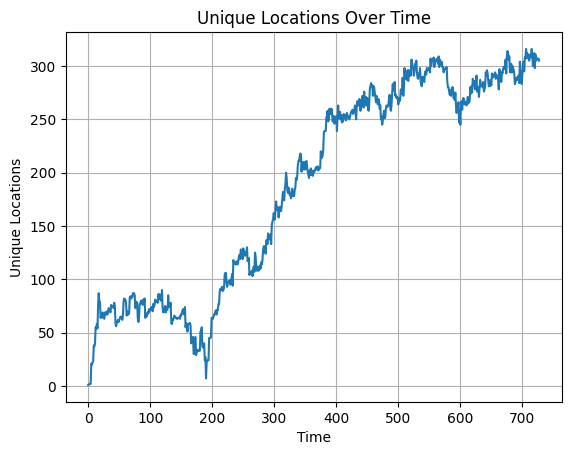

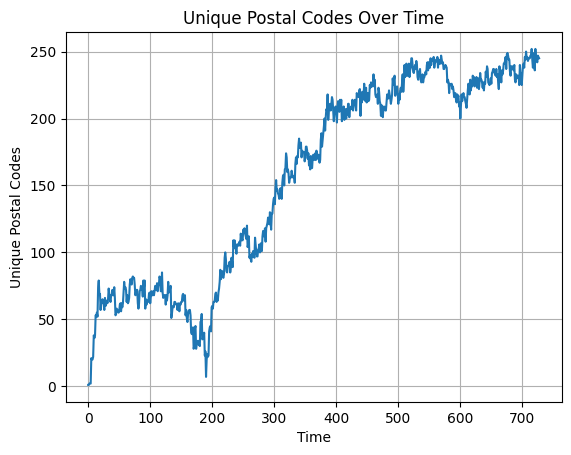

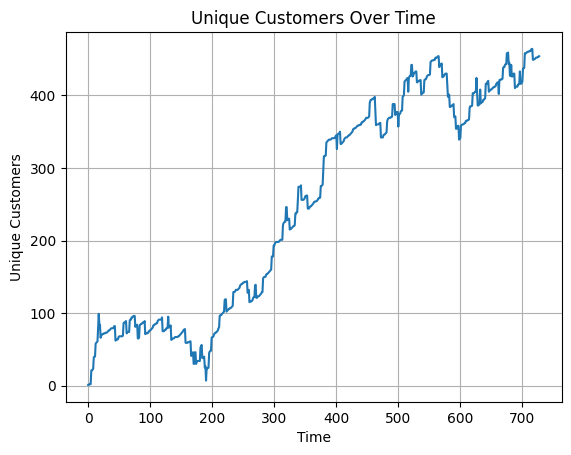

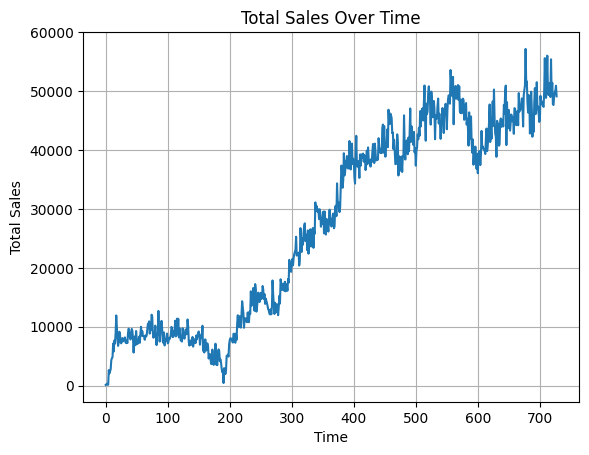

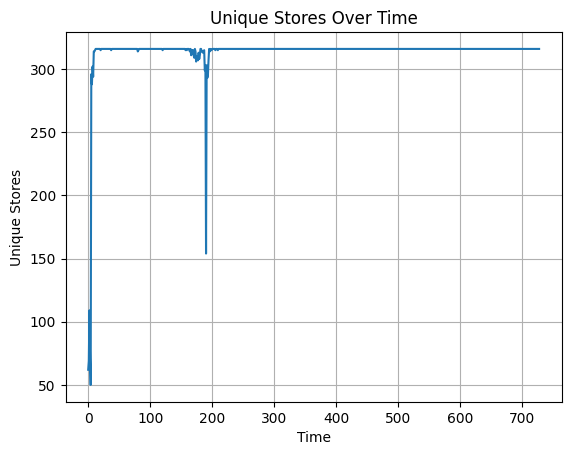

In [7]:
pd_agg_df= agg_df.toPandas()
# Plot for unique_locations
plt.figure()
plt.plot(pd_agg_df['unique_locations'])
plt.title('Unique Locations Over Time')
plt.xlabel('Time')
plt.ylabel('Unique Locations')
plt.grid(True)
plt.show()

# Plot for unique_postal_codes
plt.figure()
plt.plot(pd_agg_df['unique_postal_codes'])
plt.title('Unique Postal Codes Over Time')
plt.xlabel('Time')
plt.ylabel('Unique Postal Codes')
plt.grid(True)
plt.show()

# Plot for unique_customers
plt.figure()
plt.plot(pd_agg_df['unique_customers'])
plt.title('Unique Customers Over Time')
plt.xlabel('Time')
plt.ylabel('Unique Customers')
plt.grid(True)
plt.show()

# Plot for total_sales
plt.figure()
plt.plot(pd_agg_df['total_sales'])
plt.title('Total Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Plot for unique_stores
plt.figure()
plt.plot(pd_agg_df['unique_stores'])
plt.title('Unique Stores Over Time')
plt.xlabel('Time')
plt.ylabel('Unique Stores')
plt.grid(True)
plt.show()

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

In [9]:
# Create lagged features
window = Window.orderBy("date")
for col_name in ["unique_customers", "total_sales", "unique_locations", "unique_postal_codes", "unique_stores"]:
    for lag_num in range(1, 4):  # Create lagged features for 1, 2, 3 days
        agg_df = agg_df.withColumn(f"{col_name}_lag_{lag_num}", lag(col_name, lag_num).over(window))

# Drop rows with null values due to lagging
agg_df = agg_df.dropna()

agg_df.show()

+----------+----------------+-------------------+----------------+-----------+-------------+----------------------+----------------------+----------------------+-----------------+-----------------+-----------------+----------------------+----------------------+----------------------+-------------------------+-------------------------+-------------------------+-------------------+-------------------+-------------------+
|      date|unique_locations|unique_postal_codes|unique_customers|total_sales|unique_stores|unique_customers_lag_1|unique_customers_lag_2|unique_customers_lag_3|total_sales_lag_1|total_sales_lag_2|total_sales_lag_3|unique_locations_lag_1|unique_locations_lag_2|unique_locations_lag_3|unique_postal_codes_lag_1|unique_postal_codes_lag_2|unique_postal_codes_lag_3|unique_stores_lag_1|unique_stores_lag_2|unique_stores_lag_3|
+----------+----------------+-------------------+----------------+-----------+-------------+----------------------+----------------------+----------------

In [10]:
# def create_pipeline(label_col):
#     feature_cols = [col for col in agg_df.columns if 'lag' in col and label_col in col]
#     assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
#     lr = LinearRegression(featuresCol="features", labelCol=label_col)
#     dt = DecisionTreeRegressor(featuresCol="features", labelCol=label_col)
#     rf = RandomForestRegressor(featuresCol="features", labelCol=label_col)
    
#     return Pipeline(stages=[assembler, lr]), Pipeline(stages=[assembler, dt]), Pipeline(stages=[assembler, rf])

# def create_param_grid(model):
#     if isinstance(model.stages[-1], LinearRegression):
#         return ParamGridBuilder() \
#             .addGrid(model.stages[-1].regParam, [0.01, 0.1, 0.5]) \
#             .addGrid(model.stages[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
#             .build()
#     elif isinstance(model.stages[-1], DecisionTreeRegressor):
#         return ParamGridBuilder() \
#             .addGrid(model.stages[-1].maxDepth, [3, 5, 7]) \
#             .addGrid(model.stages[-1].maxBins, [20, 32, 50]) \
#             .build()
#     elif isinstance(model.stages[-1], RandomForestRegressor):
#         return ParamGridBuilder() \
#             .addGrid(model.stages[-1].numTrees, [10, 20, 30]) \
#             .addGrid(model.stages[-1].maxDepth, [5, 10, 15]) \
#             .build()

# def create_cross_validator(pipeline, param_grid, label_col):
#     evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
#     return CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [47]:
def train_and_evaluate_model(model_name, metric_name, train_data, test_data):
    # Create pipeline and parameter grid based on the model name
    if model_name == "LinearRegression":
        model = LinearRegression(labelCol=metric_name)
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.01, 0.1, 0.5]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()
    elif model_name == "DecisionTreeRegressor":
        model = DecisionTreeRegressor(labelCol=metric)
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [3, 5, 7]) \
            .addGrid(model.maxBins, [20, 32, 50]) \
            .build()
    elif model_name == "RandomForestRegressor":
        model = RandomForestRegressor(labelCol=metric)
        param_grid = ParamGridBuilder() \
            .addGrid(model.numTrees, [10, 20, 30]) \
            .addGrid(model.maxDepth, [5, 10, 15]) \
            .build()
    else:
        raise ValueError("Invalid model name. Supported models: LinearRegression, DecisionTreeRegressor, RandomForestRegressor")
    
    # Assemble features
    feature_cols = [col for col in train_data.columns if 'lag' in col and metric_name in col]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    # Create pipeline
    pipeline = Pipeline(stages=[assembler, model])
    
    # Define evaluator
    evaluator = RegressionEvaluator(labelCol=metric_name, predictionCol="prediction", metricName="mae")
    
    # Perform cross-validation to tune hyperparameters
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
    
    # Train model
    cv_model = cv.fit(train_data)
    
    # Evaluate on training data
    train_predictions = cv_model.transform(train_data)
    train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
    train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
    train_r2 = evaluator.evaluate(train_predictions, {evaluator.metricName: "r2"})
    
    # Evaluate on test data
    test_predictions = cv_model.transform(test_data)
    test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
    test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
    test_r2 = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})
    
    print(f"Metrics for {model_name} on {metric_name}:")
    print(f"Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R^2: {train_r2}")
    print(f"Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R^2: {test_r2}")
    print(f"Avergae metrics: {cv_model.avgMetrics}")
    
    return cv_model.bestModel

In [31]:
# Define metrics to forecast
metrics = ["unique_customers", "total_sales", "unique_locations", "unique_postal_codes", "unique_stores"]

In [38]:
# Split the data into training (80%) (cross validation applied later), and test (20%) sets
split_date = "2024-05-01"
train_df = agg_df.filter(col("date")<split_date)
test_df = agg_df.filter(col("date")>=split_date)
train_df.show()
test_df.show()

+----------+----------------+-------------------+----------------+-----------+-------------+----------------------+----------------------+----------------------+-----------------+-----------------+-----------------+----------------------+----------------------+----------------------+-------------------------+-------------------------+-------------------------+-------------------+-------------------+-------------------+
|      date|unique_locations|unique_postal_codes|unique_customers|total_sales|unique_stores|unique_customers_lag_1|unique_customers_lag_2|unique_customers_lag_3|total_sales_lag_1|total_sales_lag_2|total_sales_lag_3|unique_locations_lag_1|unique_locations_lag_2|unique_locations_lag_3|unique_postal_codes_lag_1|unique_postal_codes_lag_2|unique_postal_codes_lag_3|unique_stores_lag_1|unique_stores_lag_2|unique_stores_lag_3|
+----------+----------------+-------------------+----------------+-----------+-------------+----------------------+----------------------+----------------

In [39]:
print("Shape of Train DataFrame: ({}, {})".format(train_df.count(), len(train_df.columns)))
print("Shape of Test DataFrame: ({}, {})".format(test_df.count(), len(test_df.columns)))

Shape of Train DataFrame: (482, 21)
Shape of Test DataFrame: (243, 21)


In [45]:
# import the regression module
from pycaret.regression import *

pd_train= train_df.select("date", "total_sales", 'unique_locations', 'unique_postal_codes', "unique_customers", "unique_stores").toPandas()
pd_test= test_df.select("date", "total_sales", 'unique_locations', 'unique_postal_codes', "unique_customers", "unique_stores").toPandas()
print(pd_train.shape)
print(pd_test.shape)
print()

# initialize setup
s = setup(data = pd_train, test_data = pd_test, target = 'total_sales', fold_strategy = 'timeseries', numeric_features = ['unique_locations', 'unique_postal_codes', "unique_customers", "unique_stores"], fold =5, data_split_shuffle= False, fold_shuffle=False, index=False, transform_target = True, session_id = 123)

(482, 6)
(243, 6)


,Description,Value
0,Session id,123
1,Target,total_sales
2,Target type,Regression
3,Original data shape,"(725, 6)"
4,Transformed data shape,"(725, 6)"
5,Transformed train set shape,"(482, 6)"
6,Transformed test set shape,"(243, 6)"
7,Numeric features,4
8,Categorical features,1
9,Preprocess,True


In [46]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,4407.0317,38938024.0500,5272.2758,-1.2276,0.3811,0.3385,0.0260
par,Passive Aggressive Regressor,4776.9526,37009856.1800,5347.0836,-2.4588,0.3607,0.3636,0.0260
huber,Huber Regressor,5893.5944,96711122.2636,6381.0531,-3.1023,0.4224,0.3577,0.0300
en,Elastic Net,6428.0010,80039489.1944,7018.1921,-2.8035,0.4752,0.4070,0.0240
omp,Orthogonal Matching Pursuit,6587.1110,68355570.1237,7293.0902,-5.1692,0.4174,0.3986,0.0300
lasso,Lasso Regression,7348.1894,111920867.0630,7963.4454,-4.0722,0.5412,0.4361,0.5040
llar,Lasso Least Angle Regression,7371.8795,111819115.9957,7991.9949,-4.0962,0.5413,0.4367,0.0220
et,Extra Trees Regressor,8107.2738,108004123.3046,8734.4708,-8.7111,0.4731,0.3884,0.0540
lightgbm,Light Gradient Boosting Machine,12135.2817,264856386.5769,12675.4720,-26.6990,0.7318,0.5208,0.0500
lar,Least Angle Regression,12287.3953,263549770.3760,12927.6872,-25.8087,0.7932,0.5610,0.0220


In [48]:
# Train and evaluate models for each metric
lr= "LinearRegression"
dtr= "DecisionTreeRegressor"
rfr="RandomForestRegressor"

for metric in metrics:
    train_and_evaluate_model(lr, metric, train_df, test_df)
    # Assemble features
    # feature_cols = [col for col in train_df.columns if 'lag' in col and metric in col]
    # print(feature_cols)
    # assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    # print(assembler)

    # model = LinearRegression(labelCol=metric, predictionCol="prediction", featuresCol= "features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
    
    # # Create pipeline
    # pipeline = Pipeline(stages=[assembler, model])
    # print(pipeline)
    
    # # Define evaluator
    # evaluator = RegressionEvaluator(labelCol=metric, predictionCol="prediction", metricName="mse")
    # # print(evaluator.)

    # cv_model= pipeline.fit(train_df)
    
    # # Evaluate on training data
    # train_predictions = cv_model.transform(train_df)
    # train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
    # train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
    # train_r2 = evaluator.evaluate(train_predictions, {evaluator.metricName: "r2"})
    
    # # Evaluate on test data
    # test_predictions = cv_model.transform(test_df)
    # test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
    # test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
    # test_r2 = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})
    
    # # print(f"Metrics for {}} on {metric_name}:")
    # print(f"Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R^2: {train_r2}")
    # print(f"Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R^2: {test_r2}")
    # # print(f"Avergae metrics: {cv_model.avgMetrics}")

Metrics for LinearRegression on unique_customers:
Train MSE: 42.32095789388949, Train RMSE: 6.5054560096806044, Train R^2: 0.9968318447697397
Test MSE: 57.894655350240626, Test RMSE: 7.608853747460298, Test R^2: 0.9358651974742093
Avergae metrics: [2.9175895180039846, 3.0029117575585773, 3.8221469410223805, 3.219905437261081, 3.0820025137989235, 2.8811510207243556, 3.8816736823183433, 3.6003616763909596, 2.992607422319061]
Metrics for LinearRegression on total_sales:
Train MSE: 2772661.3022184703, Train RMSE: 1665.131016532474, Train R^2: 0.9835646413762844
Test MSE: 6465102.160158889, Test RMSE: 2542.6565163542814, Test R^2: 0.5675845872885157
Avergae metrics: [1262.7006830708542, 1263.1769913297114, 1263.266371211923, 1262.6896906050968, 1262.4215151759486, 1262.4247937389077, 1262.6410494297302, 1262.4141134382653, 1262.5760163406917]
Metrics for LinearRegression on unique_locations:
Train MSE: 38.27496053183045, Train RMSE: 6.186676048721999, Train R^2: 0.9940639475626875
Test MSE: